<h1><center><font size="6">Santander EDA and Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: Santander Customer Transaction Prediction</font></center></h2>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg" width="500"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>   
  - <a href='#35'>Distribution of skew and kurtosis</a>   
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Principal Component Analysis</a>
- <a href='#6'>Model</a>
- <a href='#7'>Submission</a>  
- <a href='#8'>References</a>

# <a id='1'>Introduction</a>  

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.  

The data is anonimyzed, each row containing 200 numerical values identified just with a number.  

In the following we will explore the data, prepare it for a model, train a model and predict the target value for the test set.



# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [ ]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
import imblearn

## Load data   

Let's check what data files are available.

In [ ]:
PATH="./data/"
os.listdir(PATH)

['test.csv', 'train.csv']

Let's load the train and test data files.

In [ ]:
%%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

CPU times: user 9.49 s, sys: 3.16 s, total: 12.6 s
Wall time: 13.1 s


# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [ ]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test data have 200,000 entries and 202, respectivelly 201 columns. 

Let's glimpse train and test dataset.

In [ ]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Train contains:  

* **ID_code** (string);  
* **target**;  
* **200** numerical variables, named from **var_0** to **var_199**;

Test contains:  

* **ID_code** (string);  
* **200** numerical variables, named from **var_0** to **var_199**;


Let's check if there are any missing data. We will also chech the type of data.


In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:

missing_data(train_df)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Here we check test dataset.

In [ ]:
missing_data(test_df)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [ ]:
%%time
train_df.describe()

CPU times: user 3.06 s, sys: 282 ms, total: 3.34 s
Wall time: 3.34 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [ ]:
%time
test_df.describe()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

We can make few observations here:   

* standard deviation is relatively large for both train and test variable data;  
* min, max, mean, sdt values for train and test data looks quite close;  
* mean values are distributed over a large range.

The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for few of the features.


Let's check the distribution of **target** value in train dataset.

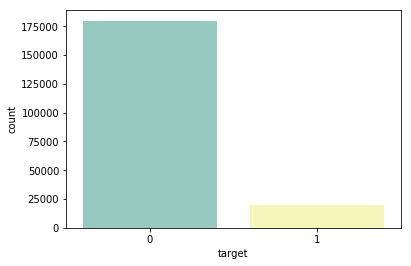

In [ ]:
sns.countplot(train_df['target'], palette='Set3')

In [ ]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


The data is highly unbalanced with respect to the **target** value.   


## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train dataset. 

We represent with different colors the distribution for values with **target** value **0** and **1**.

In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

The first 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

<Figure size 432x288 with 0 Axes>

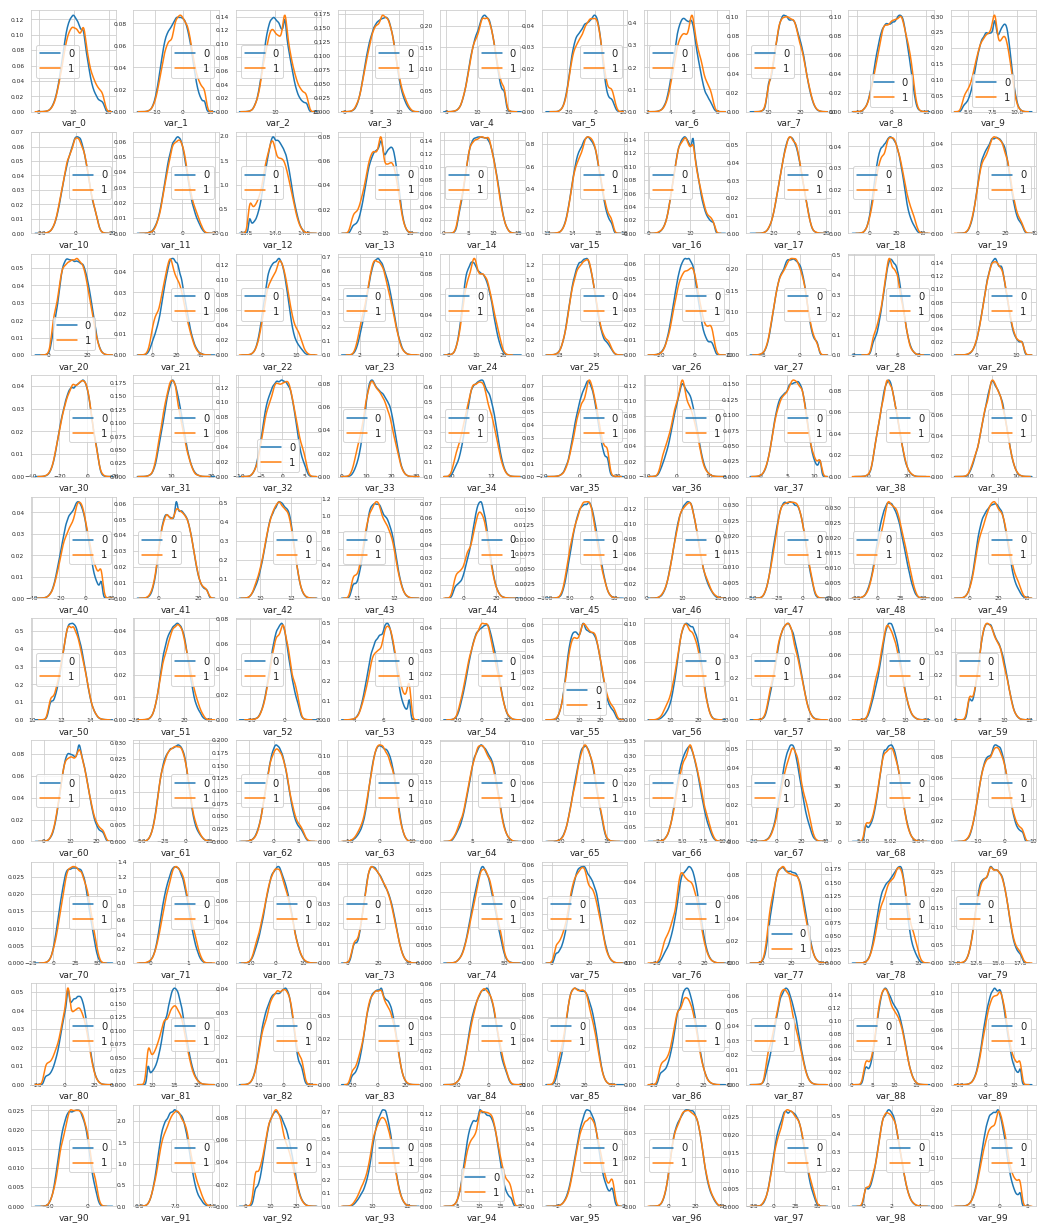

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

The next 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

<Figure size 432x288 with 0 Axes>

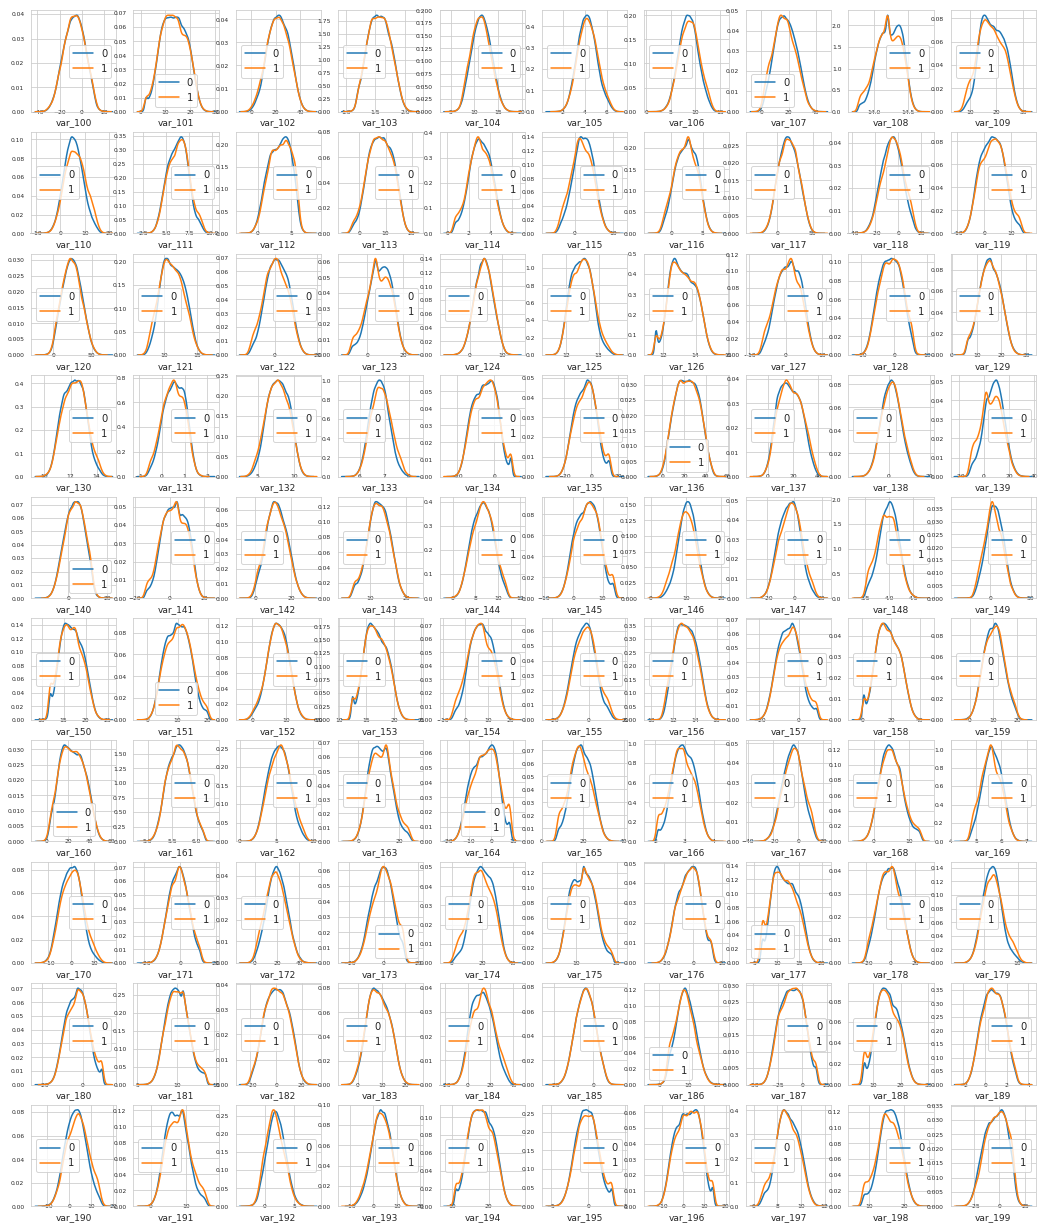

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of features with significant different distribution for the two target values.  
For example, **var_0**, **var_1**, **var_2**, **var_5**, **var_9**, **var_13**, **var_106**, **var_109**, **var_139** and many others.

Also some features, like **var_2**, **var_13**, **var_26**, **var_55**, **var_175**, **var_184**, **var_196** shows a distribution that resambles to a bivariate distribution.

We will take this into consideration in the future for the selection of the features for our prediction model.  

Le't s now look to the distribution of the same features in parallel in train and test datasets. 

The first 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

The next 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

The train and test seems to be well ballanced with respect with distribution of the numeric variables.  

## <a id='33'>Distribution of mean and std</a>  

Let's check the distribution of the mean values per row in the train and test set.

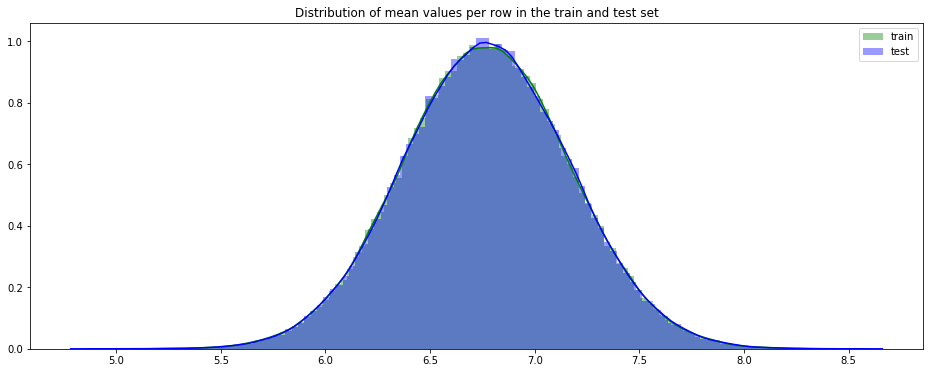

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set.

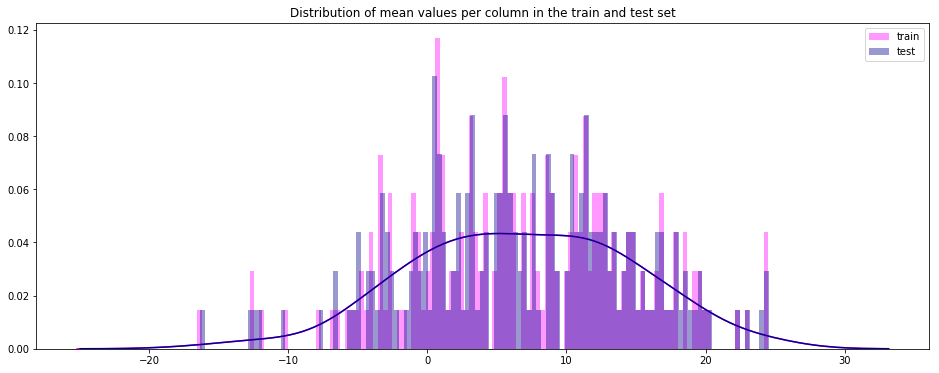

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets.

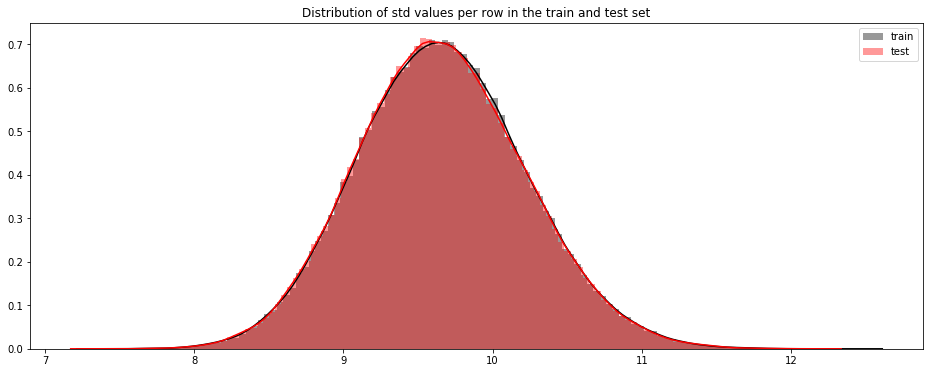

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.

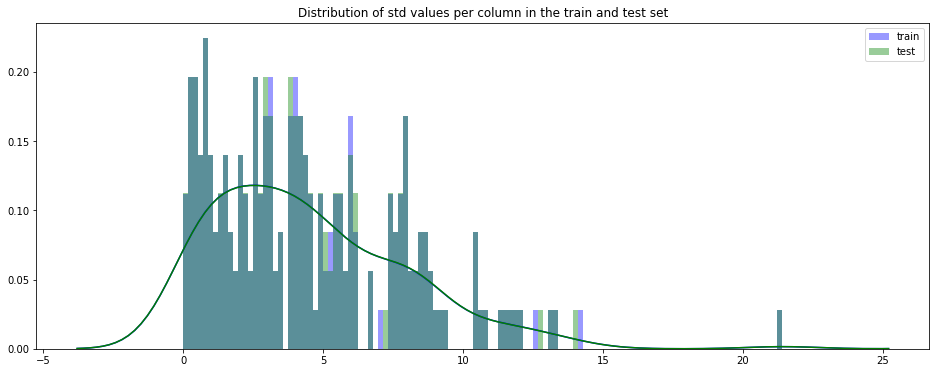

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

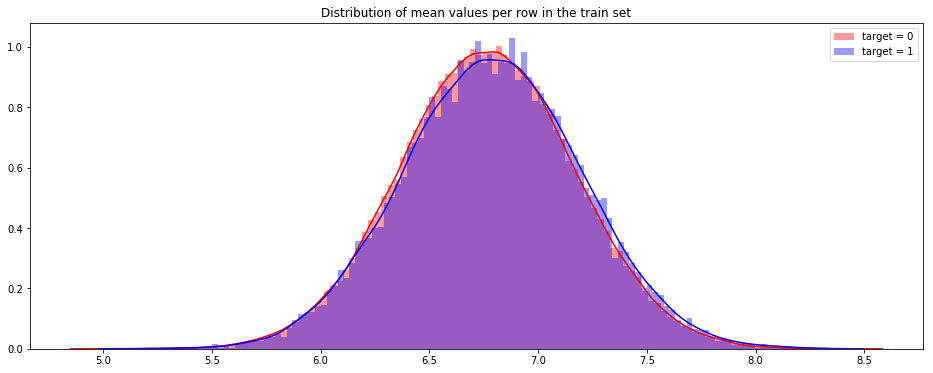

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

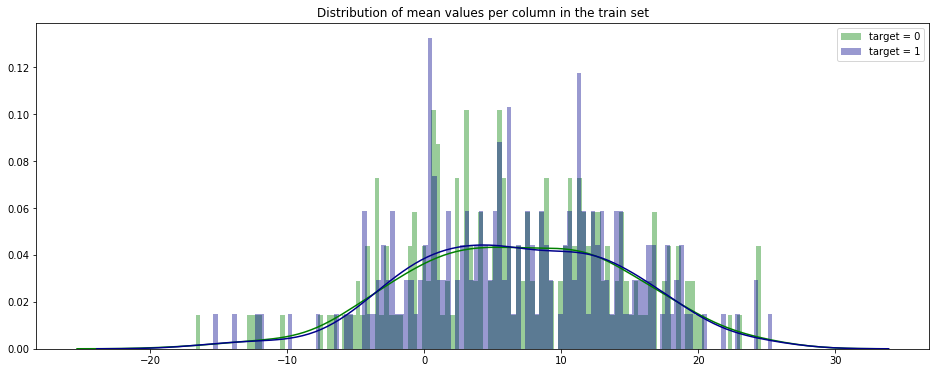

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

A long queue to the lower values for both, extended as long as to -80 for test set, is observed.

Let's now show the distribution of min per column in the train and test set.

Let's check now the distribution of max values per rows for train and test set.

## <a id='36'>Features correlation</a>  

We calculate now the correlations between the features in train set.  
The following table shows the first 10 the least correlated features.

In [ ]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 17.7 s, sys: 79.1 ms, total: 17.8 s
Wall time: 17.8 s


,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


Let's look to the top most correlated features, besides the same feature pairs.

In [ ]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


Let's see also the least correlated features.

In [ ]:
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


The correlation between the features is very small. 

## <a id='37'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [ ]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 6.63 s, sys: 0 ns, total: 6.63 s
Wall time: 6.63 s


Let's show the top 15 max of duplicate values per train set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


Let's see also the top 15 number of duplicates values per test set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# <a id='4'>Feature engineering</a>  


Let's calculate for starting few aggregated values for the existing features.

In [ ]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 15.5 s, sys: 6.98 s, total: 22.5 s
Wall time: 22.5 s


Let's check the new created features.

In [ ]:
train_df[train_df.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [ ]:
test_df[test_df.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

Let's check the distribution of these new, engineered features.  

We plot first the distribution of new features, grouped by value of corresponding `target` values.

<Figure size 432x288 with 0 Axes>

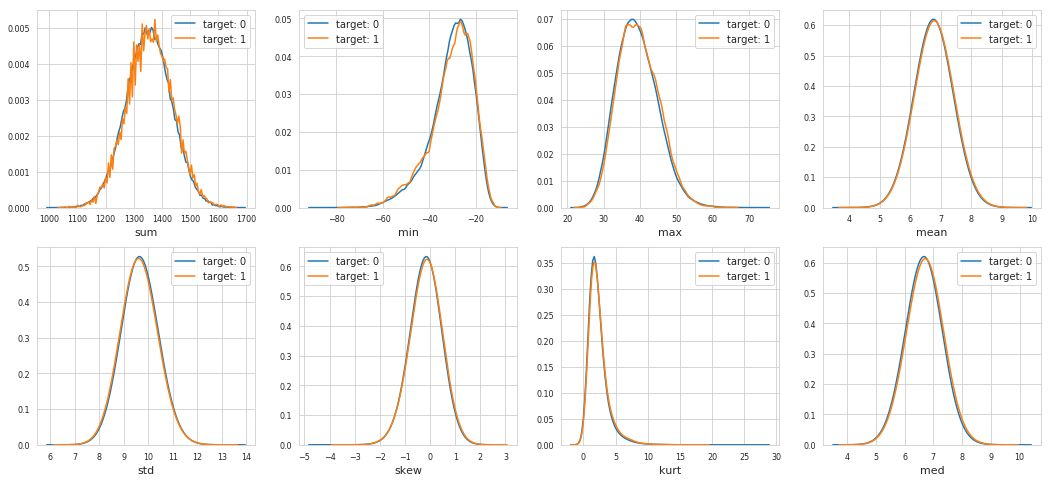

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

<Figure size 432x288 with 0 Axes>

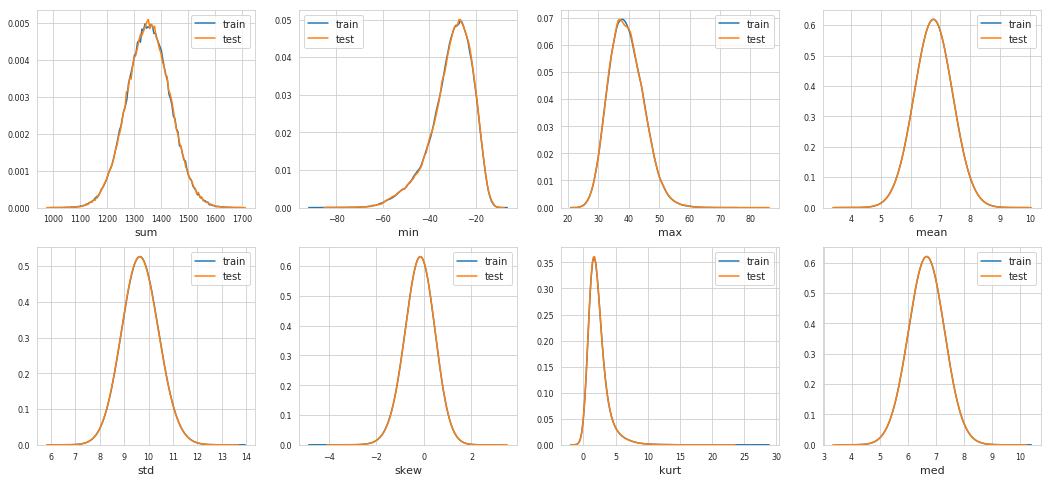

In [ ]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

We add rounded features.  


<code>
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
for feature in features:
    train_df['r2_'+feature] = np.round(train_df[feature], 2)
    test_df['r2_'+feature] = np.round(test_df[feature], 2)
    train_df['r1_'+feature] = np.round(train_df[feature], 1)
    test_df['r1_'+feature] = np.round(test_df[feature], 1)
</code>

Let's check how many features we have now.

In [ ]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209


# <a id='5'>Principal Component Analysis</a>  

In [ ]:
target = train_df['target']
train_data = train_df.drop(["ID_code", "target","sum","min","max","mean","std","skew","kurt","med"], axis=1)
test_data = test_df.drop(["ID_code","sum","min","max","mean","std","skew","kurt","med"], axis=1)
train_data.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
print(len(train_data.columns))
print(len(test_data.columns))

200
200


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(train_data)

pca = PCA()
pca.fit(X_std);

In [ ]:
# The attribute shows how much variance is explained by each of features
evr = pca.explained_variance_ratio_
evr


array([0.00611308, 0.00530267, 0.00529862, 0.00529673, 0.00528794,
       0.00528269, 0.00527948, 0.00527426, 0.00526566, 0.00526283,
       0.00525555, 0.00524994, 0.00524602, 0.00523687, 0.00523581,
       0.00523504, 0.00522727, 0.00522382, 0.00521927, 0.00521826,
       0.00521497, 0.00521018, 0.00520729, 0.00520242, 0.00519975,
       0.0051945 , 0.00519299, 0.00519256, 0.00518746, 0.00518349,
       0.00518289, 0.0051783 , 0.00517394, 0.00516921, 0.00516632,
       0.00516597, 0.00516242, 0.00515977, 0.00515468, 0.00515336,
       0.00514949, 0.00514498, 0.00514259, 0.00514111, 0.00513703,
       0.00513446, 0.00513183, 0.00512903, 0.00512785, 0.00512514,
       0.00511907, 0.00511775, 0.00511637, 0.00511503, 0.00510941,
       0.00510631, 0.00510588, 0.00510316, 0.00510131, 0.00509822,
       0.00509533, 0.00509268, 0.00509112, 0.005088  , 0.00508395,
       0.0050805 , 0.0050792 , 0.00507578, 0.00507203, 0.00506889,
       0.00506791, 0.00506343, 0.00506223, 0.00505915, 0.00505

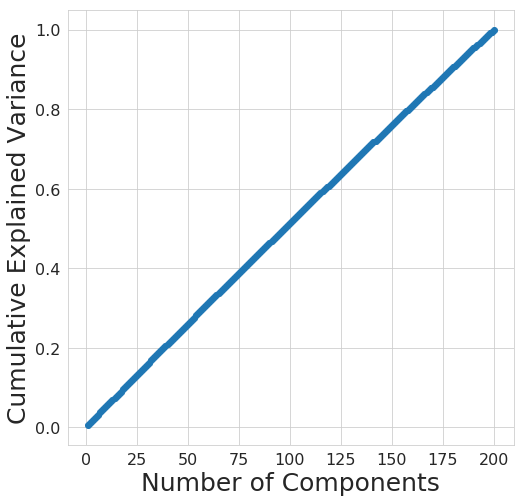

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(range(1, len(train_data.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=25)
plt.ylabel('Cumulative Explained Variance',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

the above curve is almost a straight line which implies that all components capture equal amount of variance in the data

In [ ]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.85:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 169


169 components capture 85% of the variance.

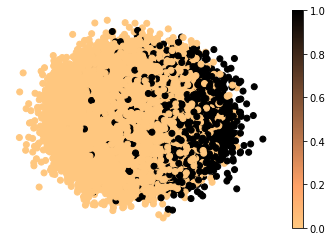

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

Above plot does not depict anything meaningful.
Let's try Kernel PCA as these classes are not linearly separable.

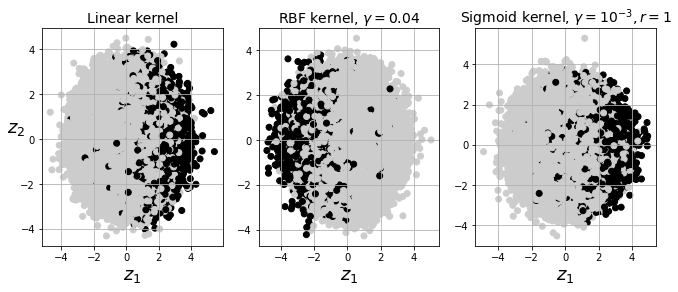

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

PCA still does not give useful results, therefore dimensionality reduction is not helpful for this dataset.